In [60]:
from __future__ import annotations
import numpy as np 
from matplotlib import pyplot as plt
import itertools
from numba import jit, int32, float32
from numba.experimental import jitclass

In [111]:

@jitclass([
    ('id', int32),
    ('x',float32),
    ('y',float32),
])
class Point:
    def __init__(self,id:int, x:float, y:float):
        self.id = id
        self.x = x
        self.y = y
    
@jit
def distance(p1:Point,p2:Point):
    return np.sqrt((p1.x-p2.x)**2 + (p1.y - p2.y)**2)

@jit
def calculate_path_length(path: list)->float:
    length = 0
    for i in range(len(path) - 1):
        length += distance(path[i], path[i+1])
    return length

# @jit
def find_greedy_salesman_path(points: list)->list:
    path = []
    remaining_points = points.copy()
    first_point_index = np.random.randint(0, len(points) - 1)
    current_point = remaining_points.pop(first_point_index)
    path.append(current_point)
        
    while len(remaining_points) > 0:
        remaining_points.sort(key= lambda p: distance(current_point, p))
        current_point = remaining_points.pop(0)
        path.append(current_point)
    return path  

# @jit
def find_brutal_salesman_path(points: list)->list:
    assert(len(points) < 9)
    points = points.copy()
    paths = list(itertools.permutations(points, len(points)))
    paths.sort(key=lambda path : calculate_path_length(path), reverse=False)
    return paths.pop(0)

In [115]:
points = [Point(1,1,2), Point(2,1,3), Point(3,1,4)]

# greedy_path
brute_path_lengths = []
greedy_path_lengths = []
random_path_lengths = []

np.random.seed(42069)

for i in range(1000):
    points = [Point(i, np.random.random(), np.random.random()) for i in range(7)]
    brute_path_lengths.append(calculate_path_length(find_brutal_salesman_path(points)))
    greedy_path_lengths.append(calculate_path_length(find_greedy_salesman_path(points)))
    random_path_lengths.append(calculate_path_length(points))
    

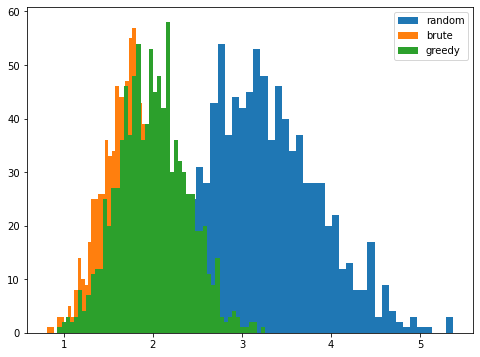

In [116]:
plt.figure(figsize=(8,6))

plt.hist(random_path_lengths, 50, label='random')
plt.hist(brute_path_lengths, 50, label='brute')
plt.hist(greedy_path_lengths, 50, label='greedy')

plt.legend()
plt.show()